In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.metrics import mean_squared_error
import re

In [2]:
df = pd.read_csv("Interval_Data.csv")
df_extracted = df
df_extracted.head()

,Date,Interval_Price,midpoint
0,2022-07-01,"[135.660004, 139.039993]",137.349998
1,2022-07-05,"[136.929993, 141.610001]",139.269997
2,2022-07-06,"[141.080002, 144.119995]",142.599998
3,2022-07-07,"[143.279999, 146.550003]",144.915001
4,2022-07-08,"[145.0, 147.550003]",146.275002


In [3]:
def str_to_interval(interval_str):
    if not isinstance(interval_str, str):
        return interval_str
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", interval_str)
    if len(numbers) == 2:
        return pd.Interval(float(numbers[0]), float(numbers[1]))
    return None

df_extracted['Interval_Price'] = df_extracted['Interval_Price'].apply(str_to_interval)
# Remove '[]' and split the interval range into two columns 'Low' and 'High'
# df_extracted[['Low', 'High']] = df_extracted['Interval_Price'].str.strip('[]').str.split('-', expand=True)

df_extracted['Low'] = df_extracted['Interval_Price'].apply(lambda x: x.left)
df_extracted['High'] = df_extracted['Interval_Price'].apply(lambda x: x.right)
df_extracted['Mid'] = df_extracted['Interval_Price'].apply(lambda x: (x.left + x.right) / 2)

# Convert 'Low' and 'High' to numeric, and calculate the 'Mid' from 'Low' and 'High'.
# df_extracted['Low'] = pd.to_numeric(df_extracted['Low'])
# df_extracted['High'] = pd.to_numeric(df_extracted['High'])
# df_extracted['Mid'] = pd.to_numeric(df_extracted['midpoint'])

df_extracted = df_extracted.drop(columns=['Interval_Price','midpoint'])
df_extracted.head()

,Date,Low,High,Mid
0,2022-07-01,135.660004,139.039993,137.349998
1,2022-07-05,136.929993,141.610001,139.269997
2,2022-07-06,141.080002,144.119995,142.599998
3,2022-07-07,143.279999,146.550003,144.915001
4,2022-07-08,145.000000,147.550003,146.275002


In [4]:
df = df_extracted
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
print(df.dtypes)

Low     float64
High    float64
Mid     float64
dtype: object


# Determine p,d,q value

### ADF test

The ADF test uses an autoregressive model and optimizes an information criterion across multiple different lag values. The p-value resulting from the ADF test is used to reject or accept the null hypothesis.

If the p-value is less than the significance level (typically 0.05), we reject the null hypothesis and infer that the time series is indeed stationary.
If the p-value is greater than the significance level, we fail to reject the null hypothesis and infer that the time series is not stationary.

In [5]:
from statsmodels.tsa.stattools import adfuller

# Iterate over the columns of df_extracted, starting from the second column
for column_name in df_extracted.columns[1:]:
    print(f"Performing ADF test for: {column_name} price")
    adf_result = adfuller(df_extracted[column_name])
    print(f"ADF Statistic for {column_name}: {adf_result[0]} price")
    print(f"p-value for {column_name}: {adf_result[1]}")
    print()

Performing ADF test for: High price
ADF Statistic for High: -0.4681254520336136 price
p-value for High: 0.8980879515378764

Performing ADF test for: Mid price
ADF Statistic for Mid: -0.434291938162224 price
p-value for Mid: 0.9042138942123279



From the results of the Augmented Dickey-Fuller test, the ADF statistics are -0.48, -0.47 and -0.43. And the P-value is 0.90, which is much larger than 0.05. As a result, we cannot refute the null hypothesis, which suggests that the time series corresponding to these prices exhibit non-stationarity.

### Autocorrelation Function (ACF)

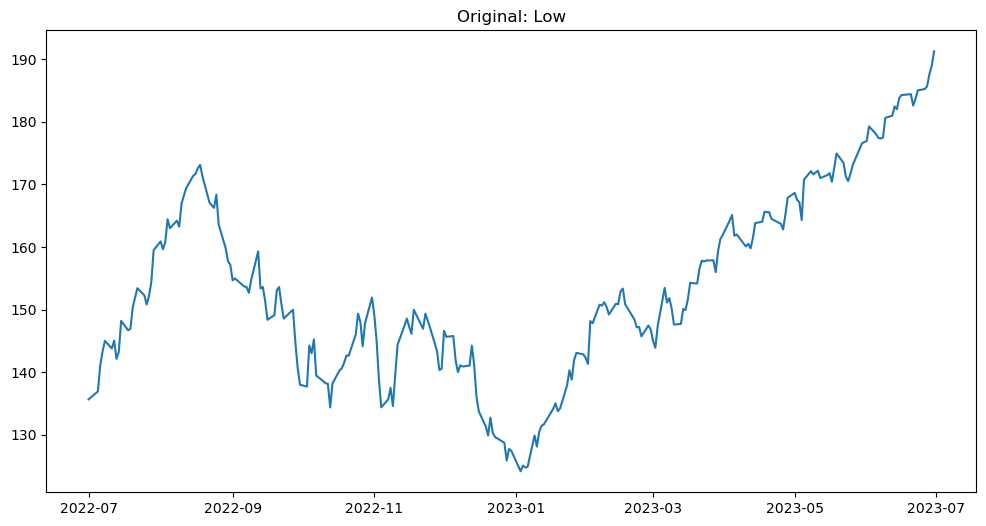

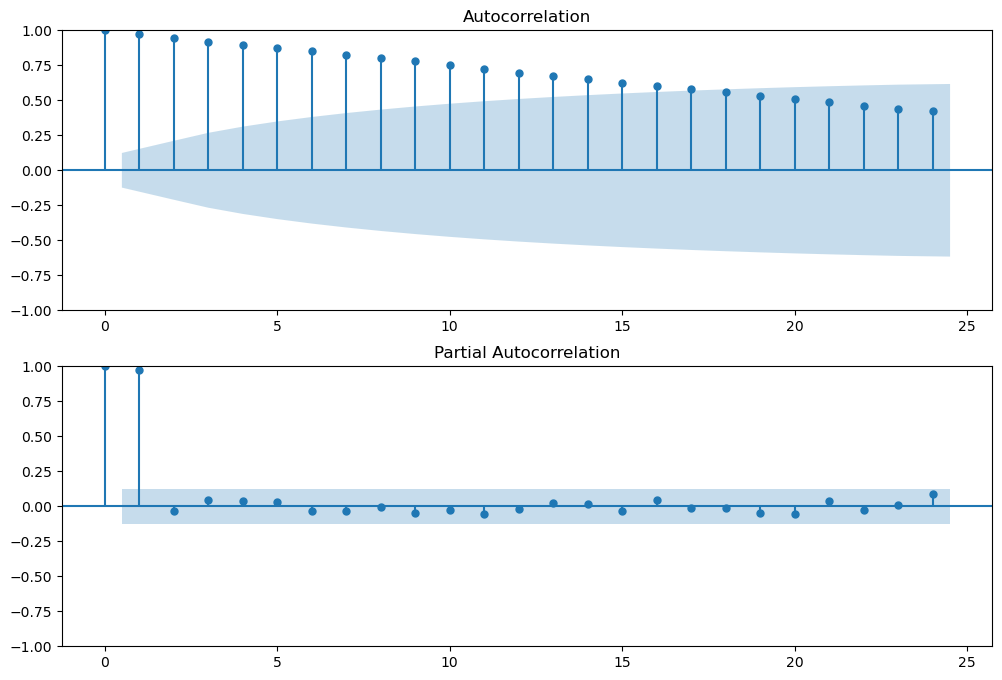

In [6]:
fig, ax1 = plt.subplots( figsize = (12,6))
ax1.plot(df_extracted['Low'].dropna())
ax1.set_title(f"Original: Low")
low_price = df['Low']

# Plot the price
fig, ax = plt.subplots(2, figsize=(12,8))
ax[0] = plot_acf(low_price, ax=ax[0])
ax[1] = plot_pacf(low_price, ax=ax[1])
plt.show()

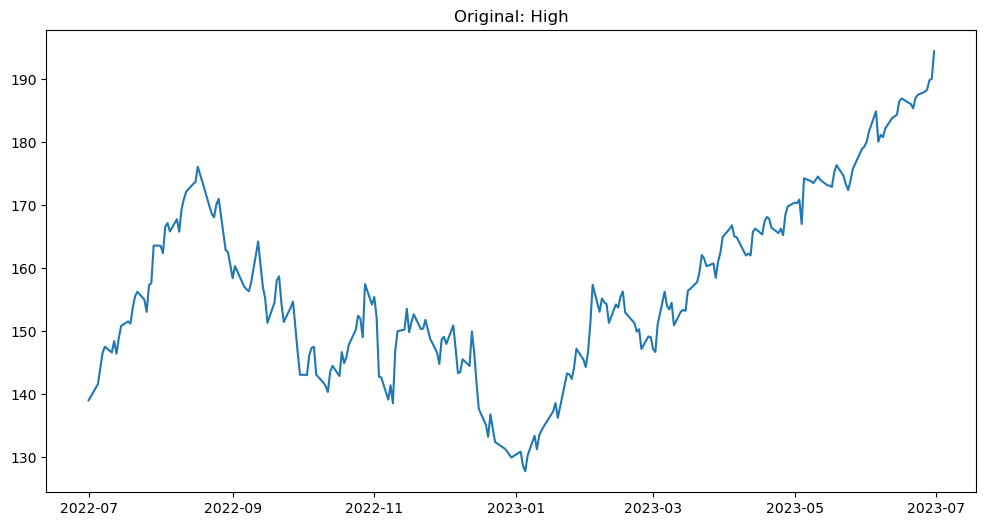

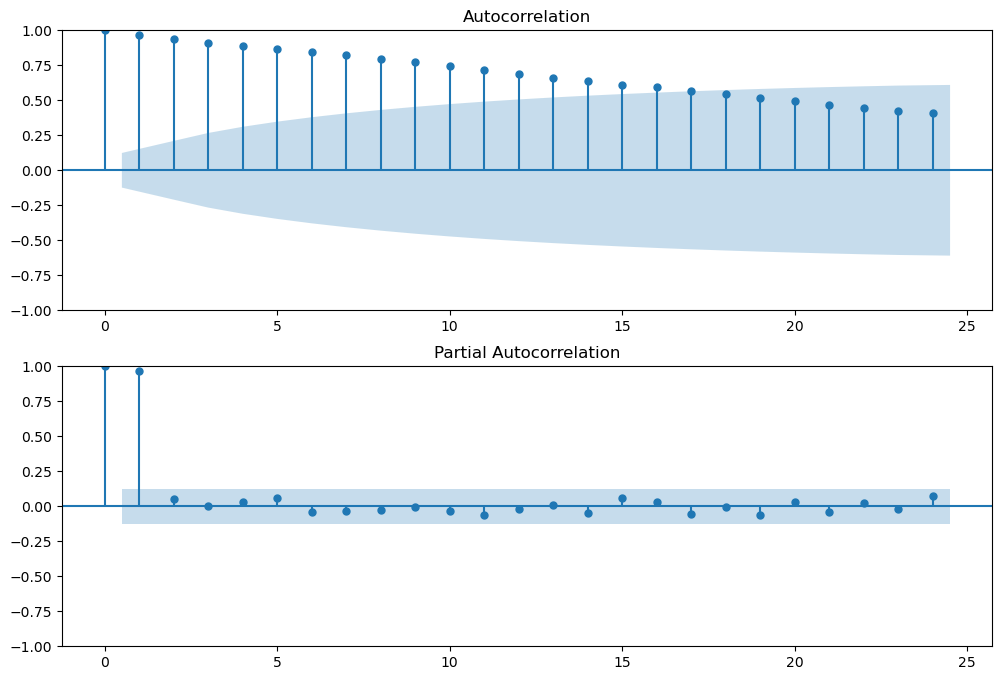

In [7]:
fig, ax1 = plt.subplots( figsize = (12,6))
ax1.plot(df_extracted['High'].dropna())
ax1.set_title(f"Original: High")
High_price = df['High']

# Plot the price
fig, ax = plt.subplots(2, figsize=(12,8))
ax[0] = plot_acf(High_price, ax=ax[0])
ax[1] = plot_pacf(High_price, ax=ax[1])
plt.show()

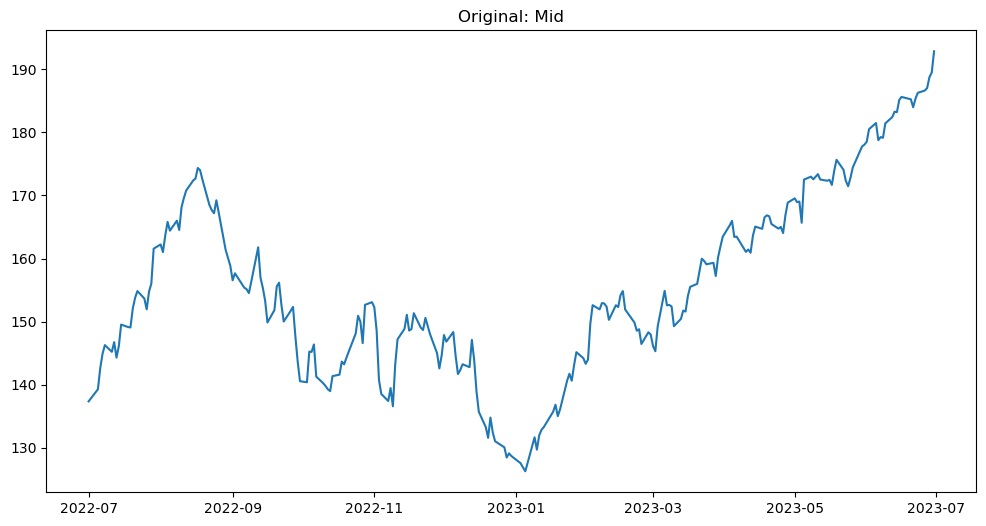

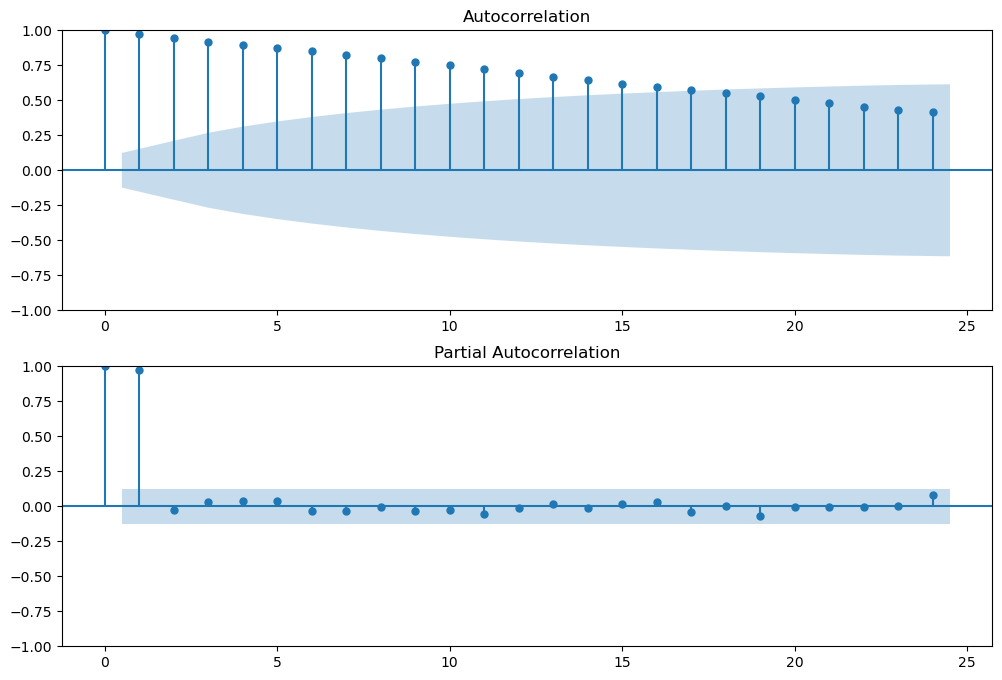

In [8]:
fig, ax1 = plt.subplots( figsize = (12,6))
ax1.plot(df_extracted['Mid'].dropna())
ax1.set_title(f"Original: Mid")
Mid_price = df['Mid']

# Plot the price
fig, ax = plt.subplots(2, figsize=(12,8))
ax[0] = plot_acf(Mid_price, ax=ax[0])
ax[1] = plot_pacf(Mid_price, ax=ax[1])
plt.show()

At the same time, I can also see from the graphs of auto-correlation function (ACF) and partial auto-correlation function (PACF) that the auto-correlation and partial auto-correlation of data are gradually decaying, which is also a feature of non-stationary sequences.

Therefore, I need to make a first-order difference on the data to make it smooth before applying the ARIMA model.

### Selecting d

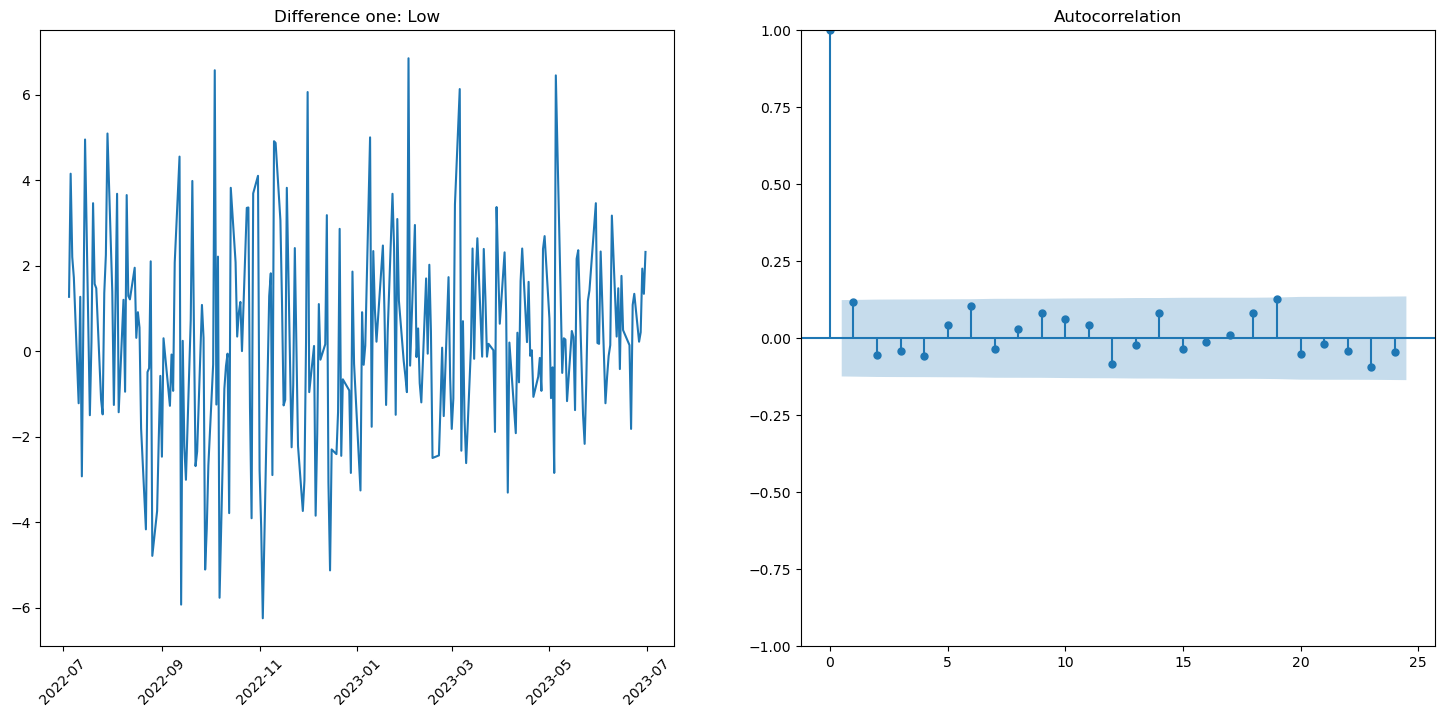

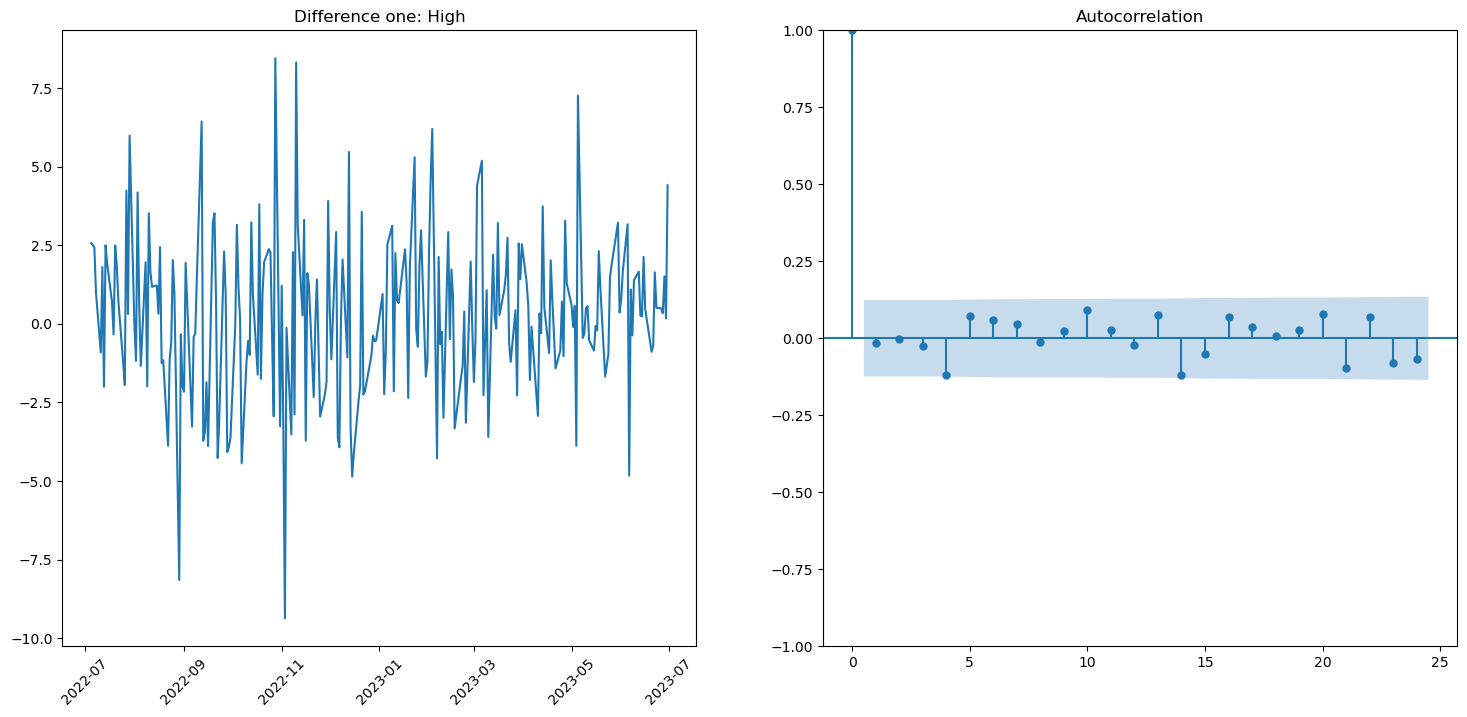

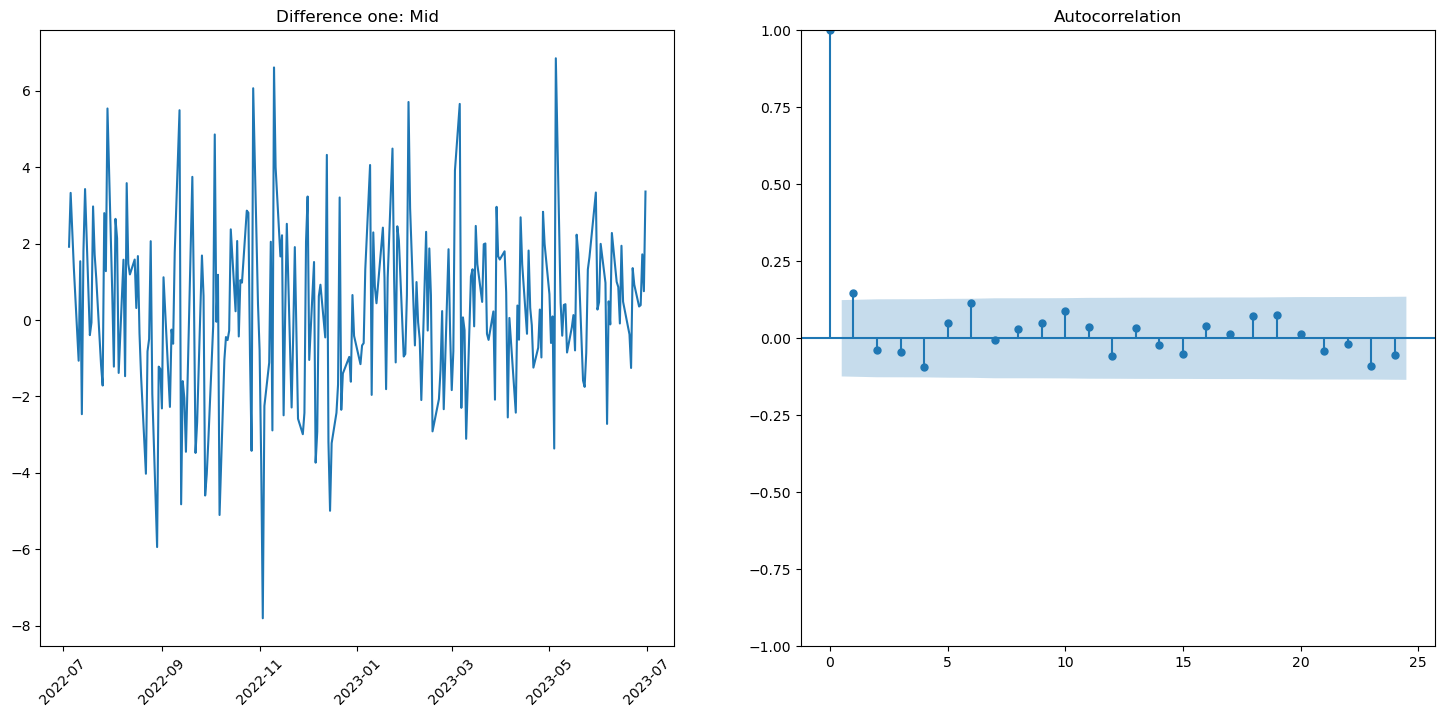

In [9]:
for price_name in df_extracted.columns[0:]:

    diff = df_extracted[price_name].diff().dropna()
    fig, (axis1, axis2) = plt.subplots( 1, 2, figsize=(18,8))
    plt.setp(axis1.get_xticklabels(), rotation=45)
    axis1.plot(diff)
    axis1.set_title(f"Difference one: {price_name}")
    plot_acf(diff, ax=axis2)

In [10]:
# Perform first order differencing
data_diff = df_extracted['Low'].diff().dropna()
# Perform the ADF test on the differenced data
result_diff = adfuller(data_diff)
result_diff[0], result_diff[1]

(-13.957380634004428, 4.5852640620525725e-26)

The ADF test result after first-order difference is as follows: the test statistic is -13.96, and the p-value is close to 0. Because the P-value is less than 0.05, we can reject the null hypothesis (the data is non-stationary) and accept the alternative hypothesis (the data is stationary). So, we can move on to fitting the ARIMA model.

In [11]:
# Perform first order differencing
data_diff = df_extracted['High'].diff().dropna()
# Perform the ADF test on the differenced data
result_diff = adfuller(data_diff)
result_diff[0], result_diff[1]

(-15.911392145494773, 8.115949910619092e-29)

The ADF test result after first-order difference is as follows: the test statistic is -15.91, and the p-value is close to 0. Because the P-value is less than 0.05, we can reject the null hypothesis (the data is non-stationary) and accept the alternative hypothesis (the data is stationary). So, we can move on to fitting the ARIMA model.

In [12]:
# Perform first order differencing
data_diff = df_extracted['Mid'].diff().dropna()
# Perform the ADF test on the differenced data
result_diff = adfuller(data_diff)
result_diff[0], result_diff[1]

(-13.515021083272432, 2.80527253859821e-25)

The ADF test result after first-order difference is as follows: the test statistic is -13.52, and the p-value is close to 0. Because the P-value is less than 0.05, we can reject the null hypothesis (the data is non-stationary) and accept the alternative hypothesis (the data is stationary). So, we can move on to fitting the ARIMA model.

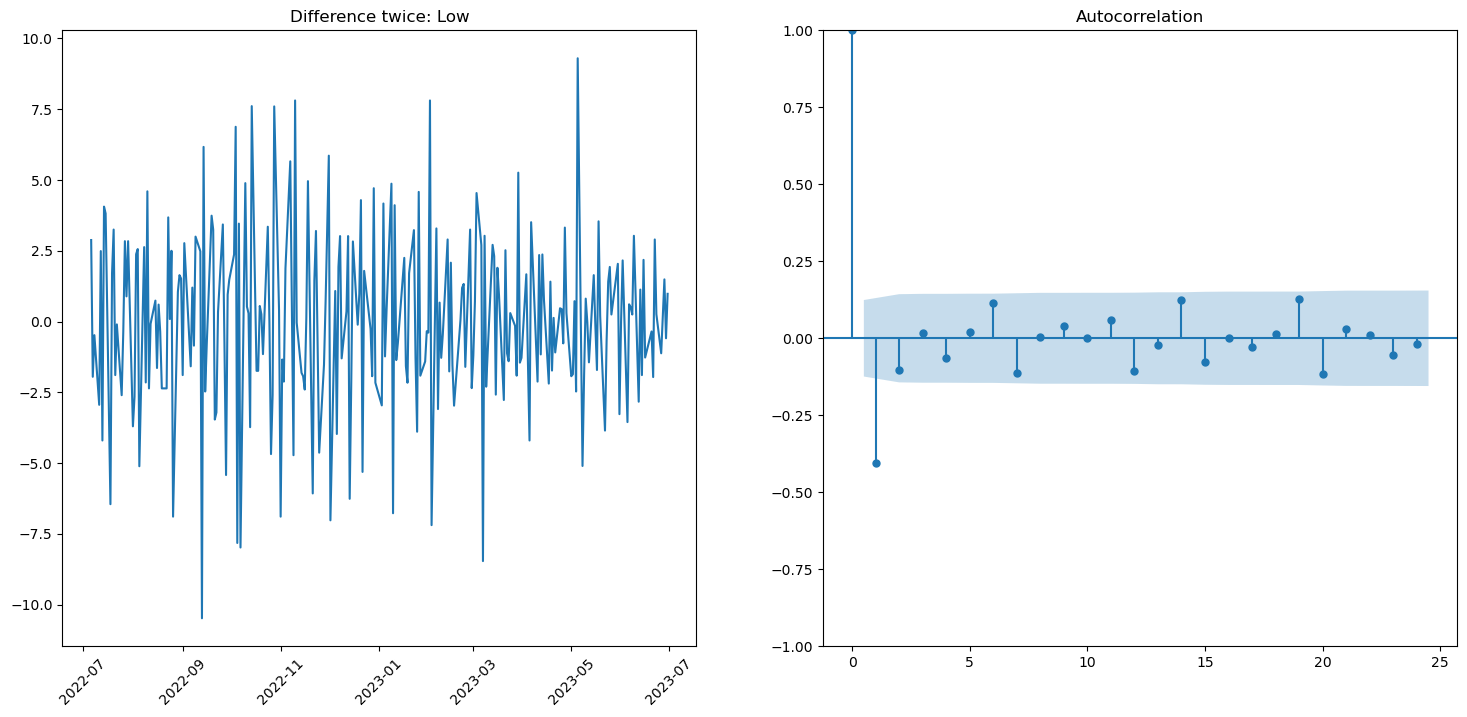

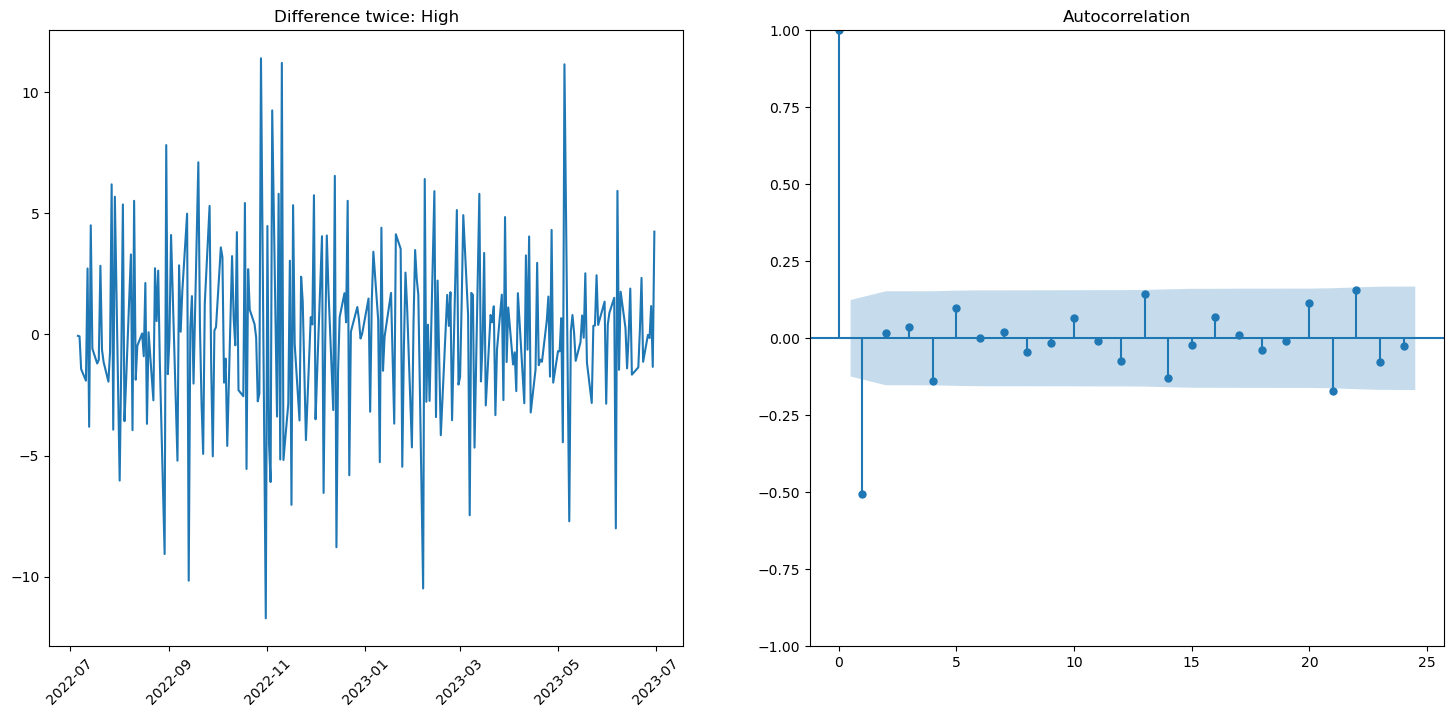

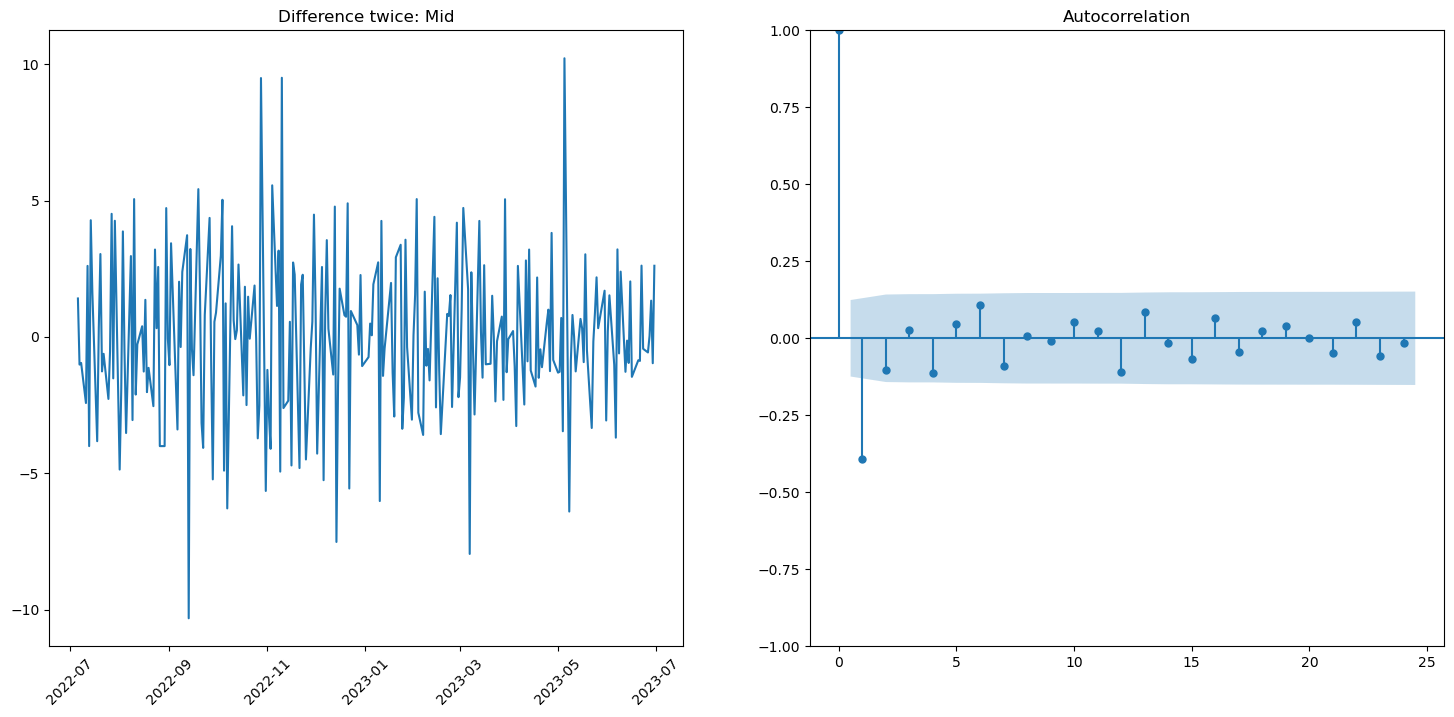

In [13]:
for price_name in df_extracted.columns[0:]:

    diff = df_extracted[price_name].diff().diff().dropna()
    fig, (axis1, axis2) = plt.subplots( 1, 2, figsize=(18,8))
    plt.setp(axis1.get_xticklabels(), rotation=45)
    axis1.plot(diff)
    axis1.set_title(f"Difference twice: {price_name}")
    plot_acf(diff, ax=axis2);

The auto-correlation observed in both "Difference one" and "Difference twice" shows minimal variance. Therefore, for all price, we should set the differencing value to 1.

The pmdarima package can also be utilized to determine the degree of differencing. The following code show an example:

In [14]:
from pmdarima.arima.utils import ndiffs
n1 = ndiffs(df_extracted.Low, test="adf")
n2 = ndiffs(df_extracted.High, test="adf")
n3 = ndiffs(df_extracted.Mid, test="adf")

print(f"The best differencing value for Low price is:", n1)
print(f"The best differencing value for High price is:", n2)
print(f"The best differencing value for Mid price is:", n3)

The best differencing value for Low price is: 1
The best differencing value for High price is: 1
The best differencing value for Mid price is: 1


As a result, I set d=1 for Low price, high price and Mid price.

### Selecting p

p is the order of the Auto Regressive (AR) term. It corresponds to the number of lags to be used as predictors. The necessary count of AR components can be ascertained by examining the Partial Auto-correlation (PACF) plot. Partial auto-correlation signifies the correlation between the time series and its lags.

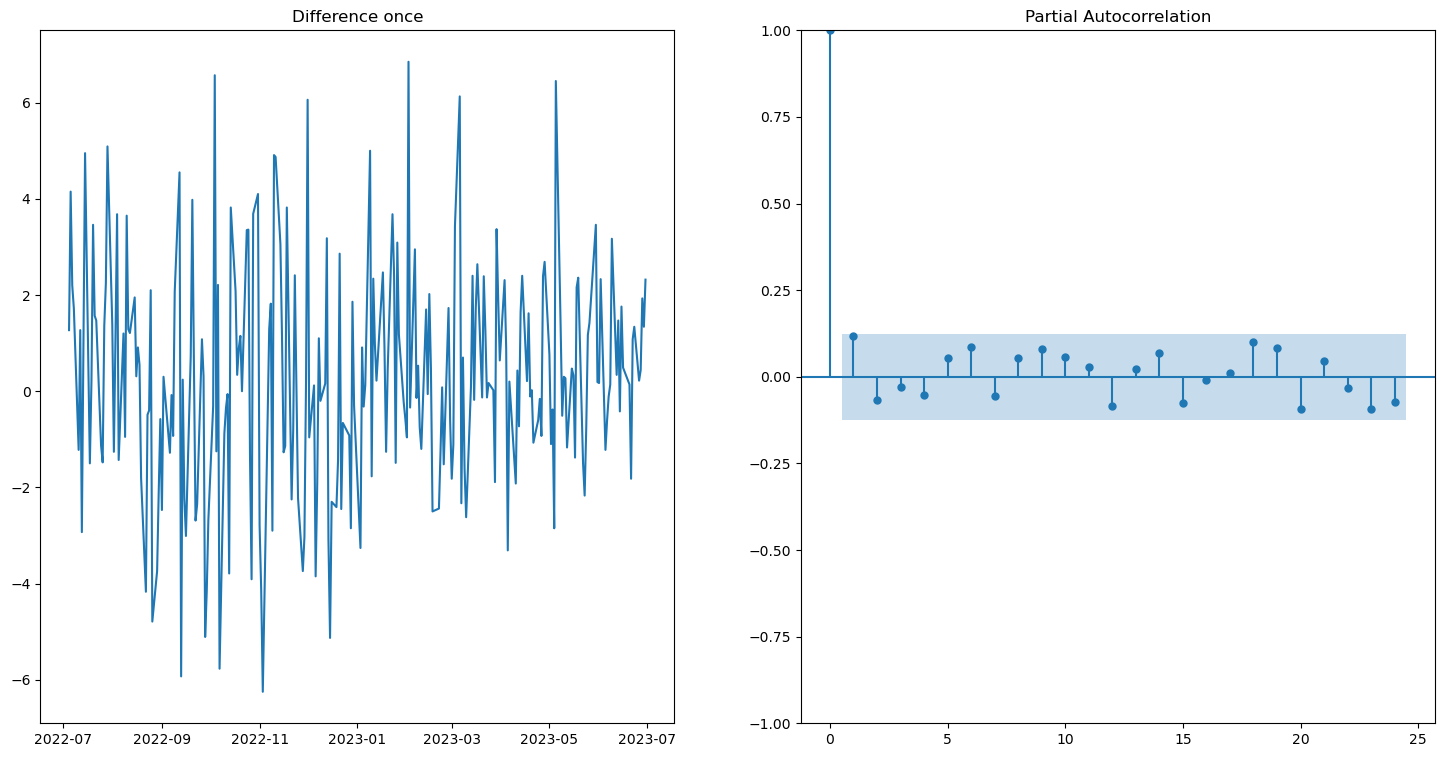

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf

# Compute the first differences of the Low prices
first_diff = df_extracted['Low'].diff().dropna()
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(18, 9))
axis1.plot(first_diff)
axis1.set_title("Difference once")
axis2.set_ylim(0, 1)

# plot the partial auto-correlation of the first differences
plot_pacf(first_diff, ax=axis2, method='ywm')
plt.show()

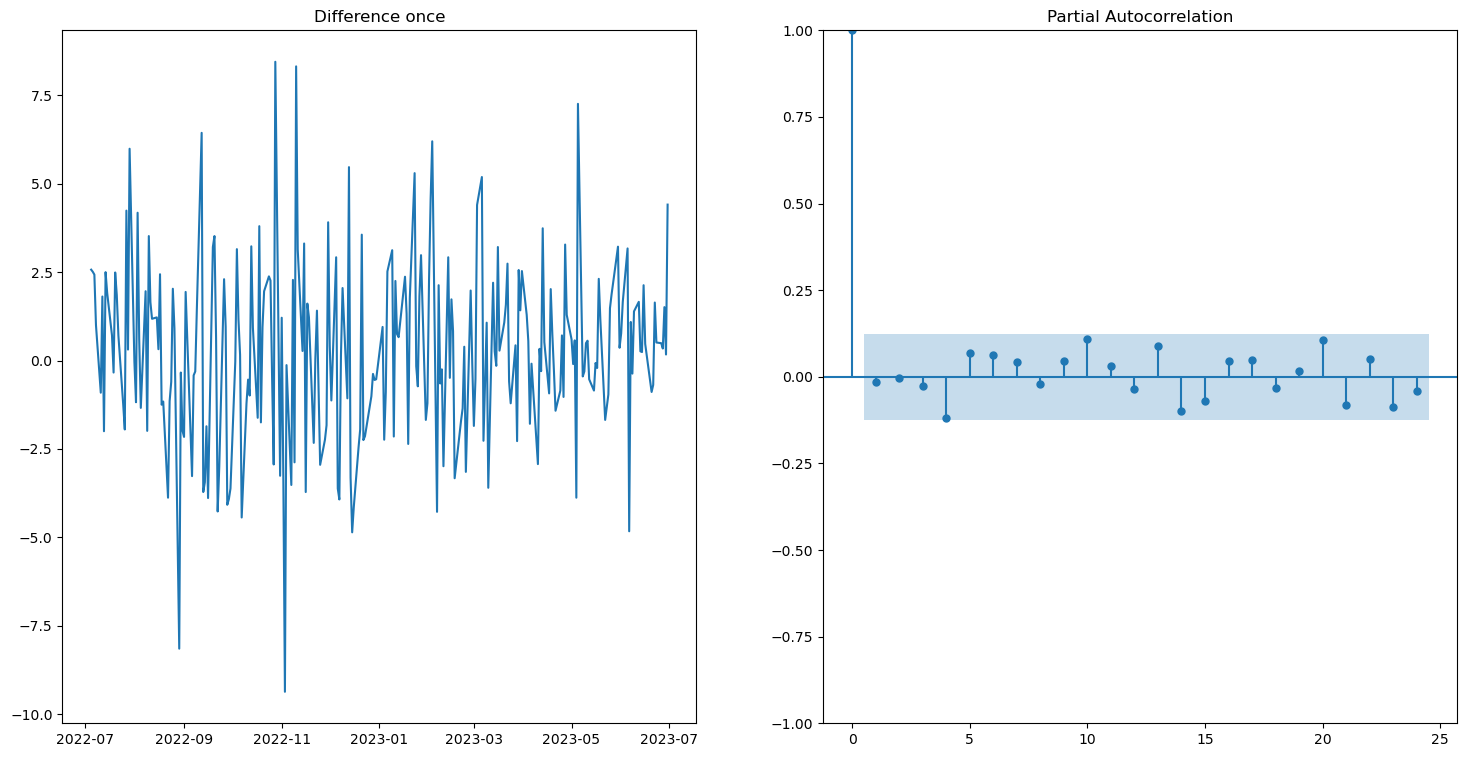

In [16]:
from statsmodels.graphics.tsaplots import plot_pacf

# Compute the first differences of the High prices
first_diff = df_extracted['High'].diff().dropna()
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(18, 9))
axis1.plot(first_diff)
axis1.set_title("Difference once")
axis2.set_ylim(0, 1)

# plot the partial auto-correlation of the first differences
plot_pacf(first_diff, ax=axis2, method='ywm')
plt.show()

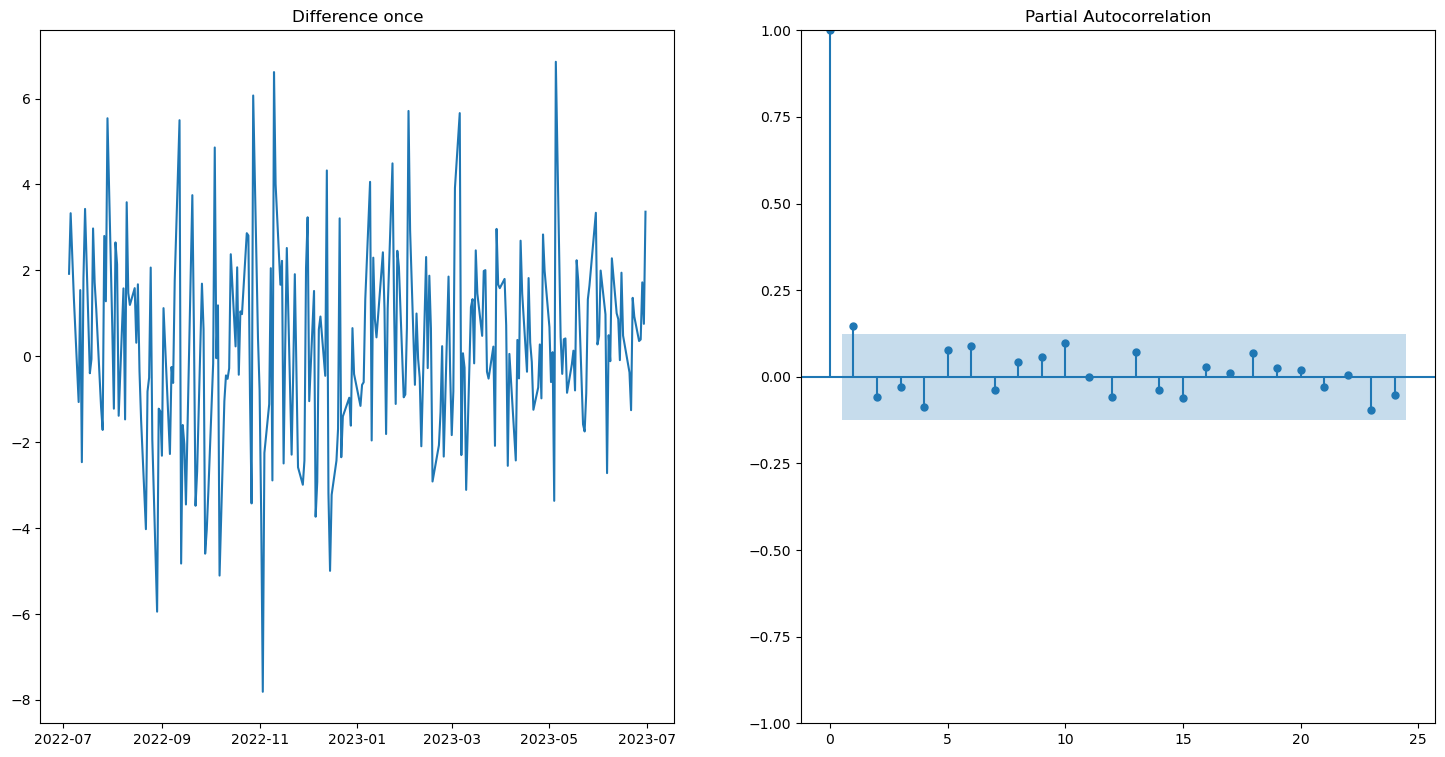

In [17]:
from statsmodels.graphics.tsaplots import plot_pacf

# Compute the first differences of the Mid prices
first_diff = df_extracted['Mid'].diff().dropna()
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(18, 9))
axis1.plot(first_diff)
axis1.set_title("Difference once")
axis2.set_ylim(0, 1)

# plot the partial auto-correlation of the first differences
plot_pacf(first_diff, ax=axis2, method='ywm')
plt.show()

From the PACF plot above, it looks like the PACF crosses the upper confidence interval for the first time at lag 1. Therefore, it might start by considering p=1 for three ARIMA models.

### Selecting q

'q' is the order of the Moving Average (MA) term. It signifies the number of lagged forecast errors that should be incorporated into the ARIMA model. The number of MA terms can be determined by inspecting the Auto-correlation Function (ACF) plot.

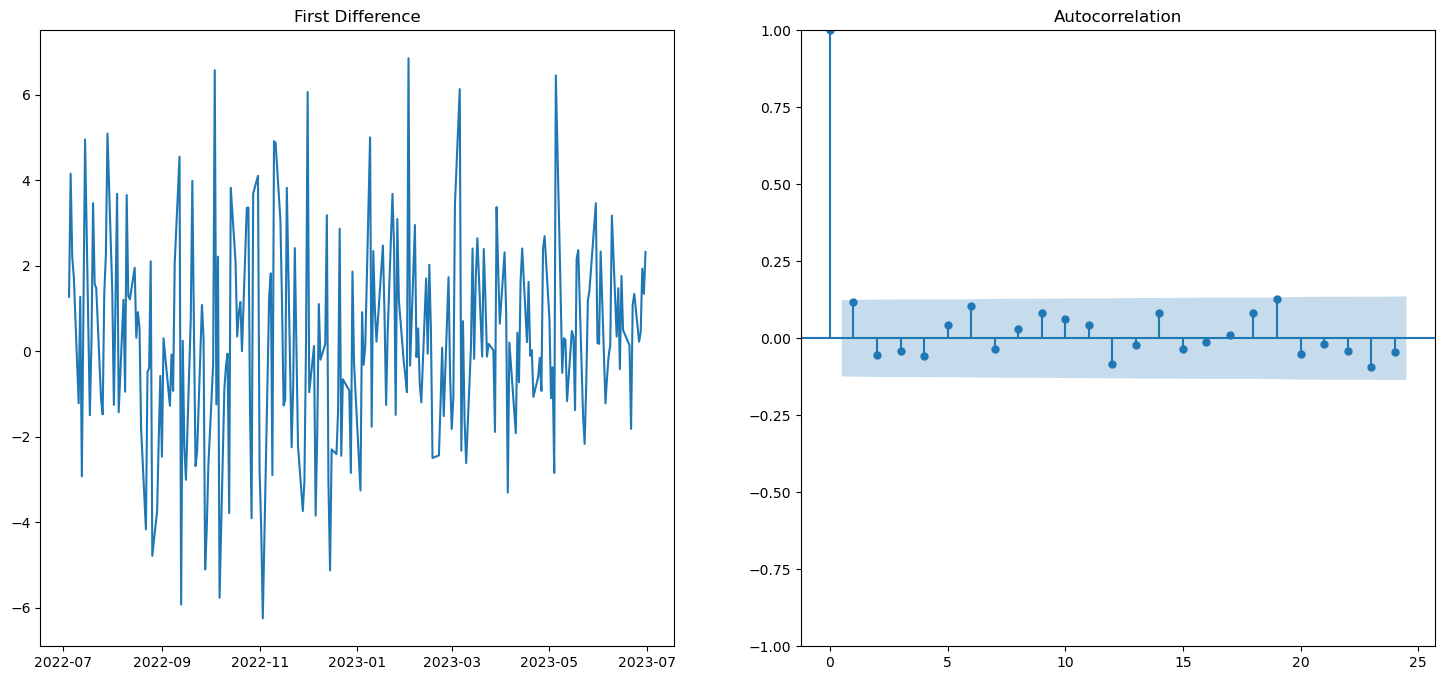

In [18]:
# Calculate the first differences of the 'Low' column
diff_low = df_extracted['Low'].diff().dropna()
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(18, 8))
axis1.plot(diff_low)
axis1.set_title("First Difference")
axis2.set_ylim(0, 1)
plot_acf(diff_low, ax=axis2)
plt.show()

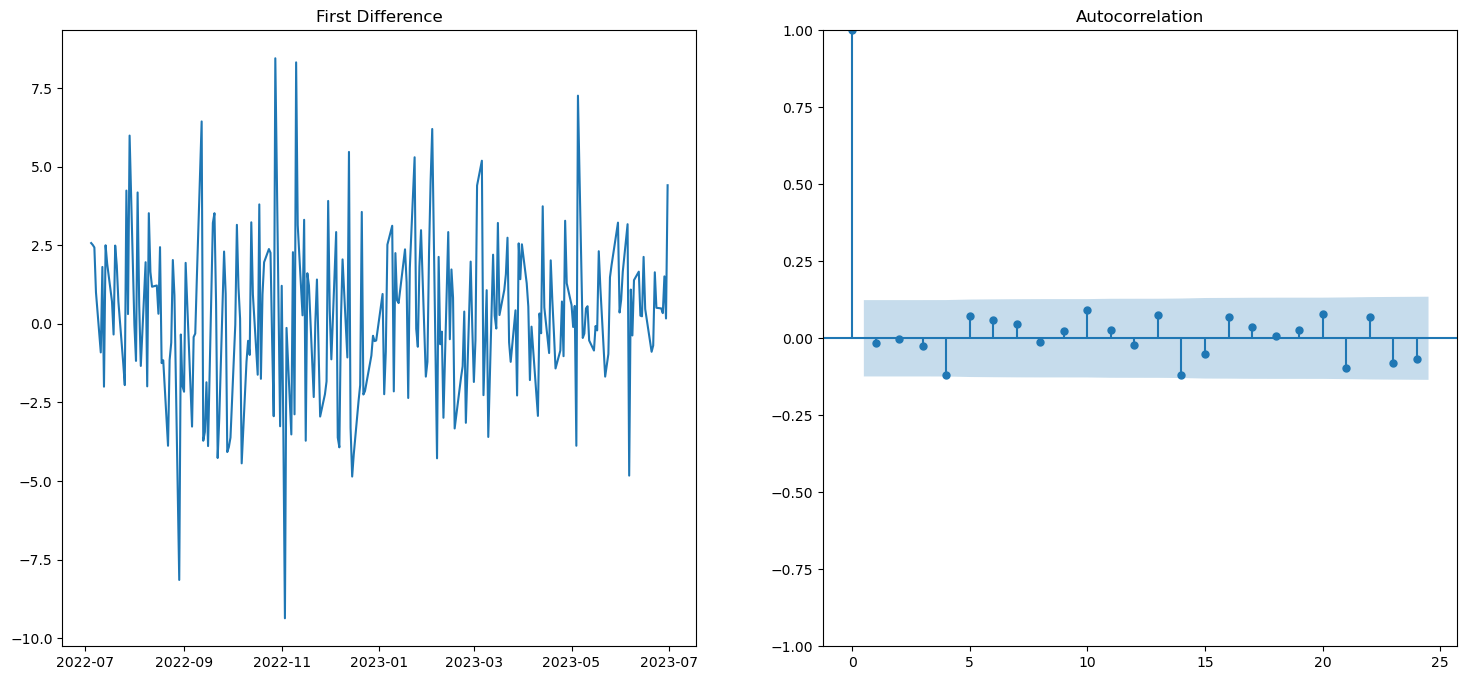

In [19]:
# Calculate the first differences of the 'High' column
diff_low = df_extracted['High'].diff().dropna()
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(18, 8))
axis1.plot(diff_low)
axis1.set_title("First Difference")
axis2.set_ylim(0, 1)
plot_acf(diff_low, ax=axis2)
plt.show()

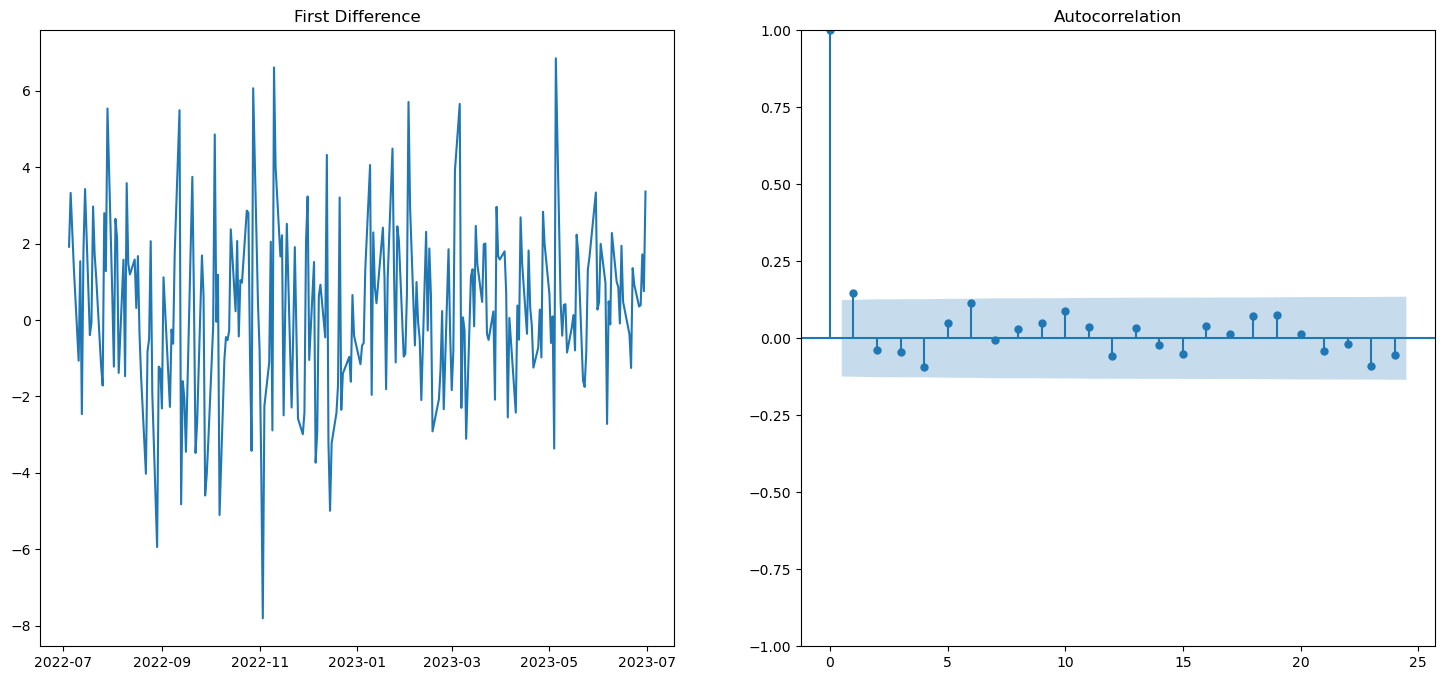

In [20]:
# Calculate the first differences of the 'Mid' column
diff_low = df_extracted['Mid'].diff().dropna()
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(18, 8))
axis1.plot(diff_low)
axis1.set_title("First Difference")
axis2.set_ylim(0, 1)
plot_acf(diff_low, ax=axis2)
plt.show()

Looking at the ACF plot, I typically consider the point where the ACF plot crosses the upper confidence interval for the first time as the q value for the ARIMA model. It is the lag after which the correlation is no longer significant.

From the ACF plot above, it looks like the ACF crosses the upper confidence interval for the first time at lag 1. Therefore, it might start by considering q=1 for my ARIMA model.

In [21]:
# Fit the ARIMA model with the optimal parameters
model = ARIMA(df_extracted['Low'], order=[1,1,1])
model_Low_price_fit = model.fit()
model_Low_price_fit.summary()

C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    Low   No. Observations:                  251
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -568.100
Date:                Sat, 12 Aug 2023   AIC                           1142.201
Time:                        17:47:45   BIC                           1152.765
Sample:                             0   HQIC                          1146.452
                                - 251                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2502      0.434     -0.576      0.564      -1.101       0.601
ma.L1          0.3828      0.418      0.916      0.360      -0.436       1.202
sigma2         5.5115      0.459     12.007      0.000       4.612       6.411
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.20
Prob(Q):                              0.90   Prob(JB):                         0.55
Heteroskedasticity (H):               0.50   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
# Fit the ARIMA model with the optimal parameters
model = ARIMA(df_extracted['High'], order=[1,1,1])
model_High_price_fit = model.fit()
model_High_price_fit.summary()

C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   High   No. Observations:                  251
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -590.197
Date:                Sat, 12 Aug 2023   AIC                           1186.395
Time:                        17:47:45   BIC                           1196.959
Sample:                             0   HQIC                          1190.647
                                - 251                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1484      6.729     -0.022      0.982     -13.337      13.040
ma.L1          0.1387      6.741      0.021      0.984     -13.074      13.351
sigma2         6.5784      0.480     13.695      0.000       5.637       7.520
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                11.33
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                            -0.00
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
# Fit the ARIMA model with the optimal parameters
model = ARIMA(df_extracted['Mid'], order=[1,1,1])
model_Mid_price_fit = model.fit()
model_Mid_price_fit.summary()

C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    Mid   No. Observations:                  251
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -557.653
Date:                Sat, 12 Aug 2023   AIC                           1121.306
Time:                        17:47:45   BIC                           1131.870
Sample:                             0   HQIC                          1125.558
                                - 251                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2044      0.402     -0.509      0.611      -0.992       0.583
ma.L1          0.3658      0.382      0.958      0.338      -0.382       1.114
sigma2         5.0694      0.393     12.898      0.000       4.299       5.840
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 5.62
Prob(Q):                              0.93   Prob(JB):                         0.06
Heteroskedasticity (H):               0.56   Skew:                             0.08
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Plot residual errors

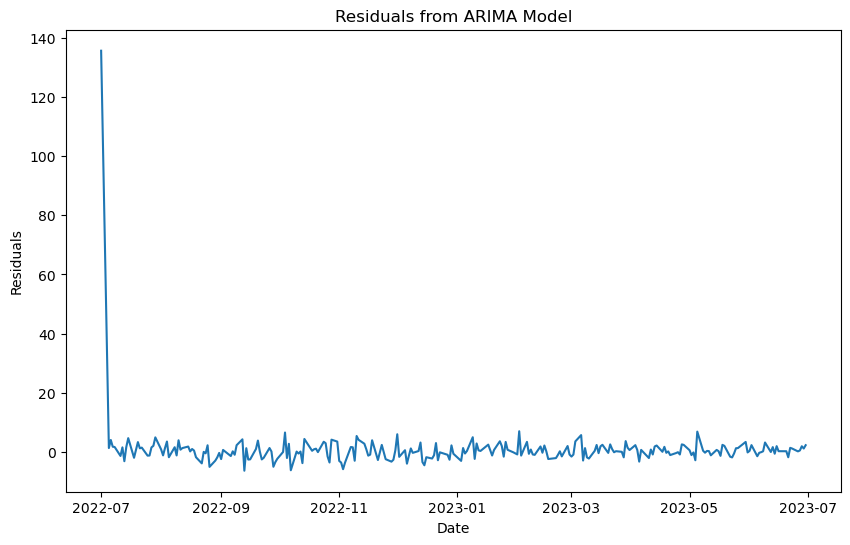

In [24]:
residuals = model_Low_price_fit.resid

# Plot residuals
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals from ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

This is the residual plot from the ARIMA model. As you can see from the graph, the residuals fluctuate roughly up and down around the 0 line, with no obvious pattern. This indicates that the model has captured the main information in the data, and there are no remaining trends or periodicity in the residuals. This is a characteristic of a good model.

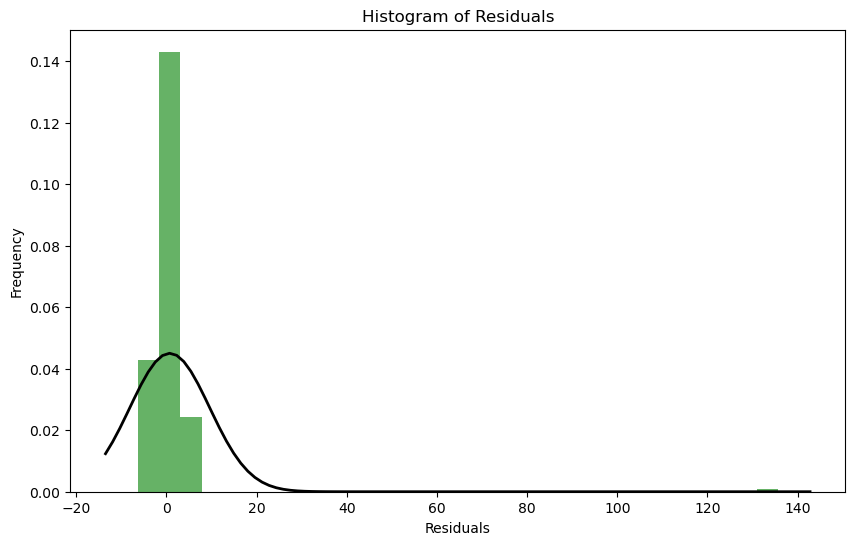

In [25]:
from scipy.stats import norm
# Plot histogram of residuals
plt.figure(figsize=(10,6))
plt.hist(residuals, bins=30, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, residuals.mean(), residuals.std())
plt.plot(x, p, 'k', linewidth=2)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

This is the histogram of the ARIMA model residuals, with the black line representing the probability density function of the normal distribution. As can be seen from the figure, the distribution of residuals is roughly symmetric and close to a normal distribution. This is a characteristic of a good model because, ideally, we want the model's residuals to be random and follow a normal distribution.

In [26]:
df_extracted.head()
data = pd.DataFrame(df_extracted[['Low']])
data.head()

,Low
Date,
2022-07-01,135.660004
2022-07-05,136.929993
2022-07-06,141.080002
2022-07-07,143.279999
2022-07-08,145.000000


C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer ind

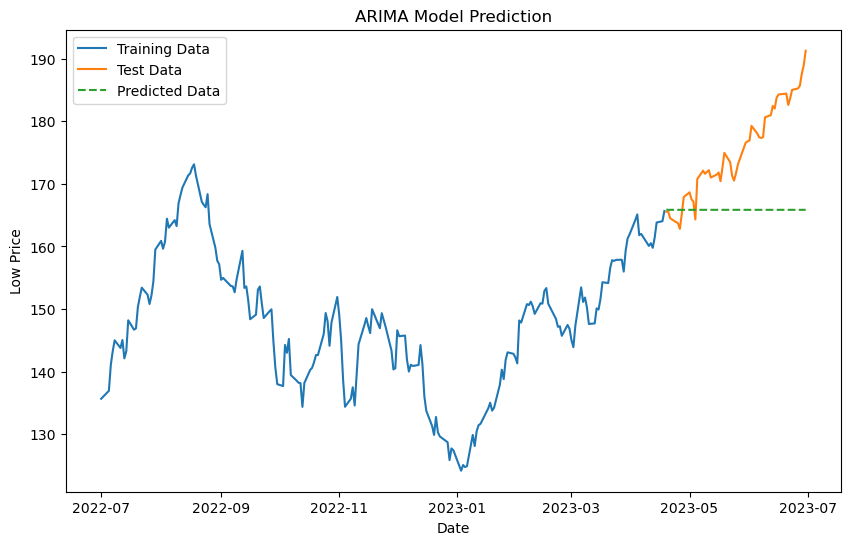

In [27]:
data = pd.DataFrame(df_extracted[['Low']])
# data['Date'] = pd.to_datetime(data['Date'])
# data.set_index('Date', inplace=True)

# Divide the data into training sets and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

start_date = pd.to_datetime(test.index.min())
end_date = pd.to_datetime(test.index.max())

# Use the best parameters to train the model
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()
forecast = model_fit.forecast(len(test))
# forecast = model_fit.predict('20220630','20230630', dynamic = True, typ = 'levels')
forecast_series = pd.Series(forecast.values, index=test.index) # Updated this line

# Draw a line chart of forecast results
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(forecast_series, label='Predicted Data', linestyle='--')
ax.legend()
ax.set_title("ARIMA Model Prediction")
ax.set_xlabel("Date")
ax.set_ylabel("Low Price")
plt.show()

In [28]:
data = pd.DataFrame(df_extracted[['Low']])
# data['Date'] = pd.to_datetime(data['Date'])
# data.set_index('Date', inplace=True)

# Divide the data into training sets and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Reinitialize lists to store predictions and Reset training data
predictions = []
predicted_dates = []
train, test = data[:train_size], data[train_size:]

# Iterate over the test data
for date in test.index:
    # Train ARIMA model
    model = ARIMA(train, order=(1,1,1))
    model_fit = model.fit()

    # Forecast the next one point
    forecast = model_fit.forecast(steps=1).values
    predictions.append(forecast[0])
    predicted_dates.append(date)

    # For the next iteration, append the actual observed value from the test data to the training data
    train = train.append(test.loc[date])

forecast_series_Low = pd.Series(predictions, index=predicted_dates)
forecast_series_Low.name = "Low_forecast"
print(forecast_series_Low.head())

C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer ind

2023-04-19    165.893535
2023-04-20    165.429272
2023-04-21    165.606187
2023-04-24    164.326738
2023-04-25    163.871538
Name: Low_forecast, dtype: float64


C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\eq220\AppData\Local\Temp\ipykernel_32024\3698292429.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(test.loc[date])
C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fo

In [29]:
mse = mean_squared_error(test, forecast_series_Low)
print(f'MSE of Low price forecast: {mse}')

MSE of Low price forecast: 2.864720396371544


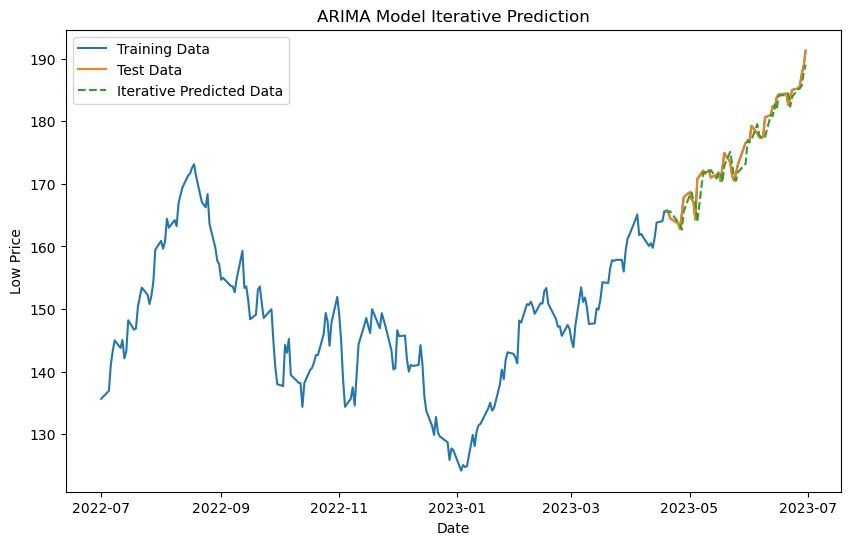

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(forecast_series_Low, label='Iterative Predicted Data', linestyle='--')
ax.legend()
ax.set_title("ARIMA Model Iterative Prediction")
ax.set_xlabel("Date")
ax.set_ylabel("Low Price")
plt.show()

In [31]:
data = pd.DataFrame(df_extracted[['High']])
# data['Date'] = pd.to_datetime(data['Date'])
# data.set_index('Date', inplace=True)

# Divide the data into training sets and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Reinitialize lists to store predictions and Reset training data
predictions = []
predicted_dates = []
train, test = data[:train_size], data[train_size:]

# Iterate over the test data
for date in test.index:
    model = ARIMA(train, order=(1,1,1))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1).values
    predictions.append(forecast[0])
    predicted_dates.append(date)
    train = train.append(test.loc[date])

forecast_series_High = pd.Series(predictions, index=predicted_dates)
forecast_series_High.name = "High_forecast"
print(forecast_series_High.head())

C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer ind

2023-04-19    167.090293
2023-04-20    168.150562
2023-04-21    167.865372
2023-04-24    166.469444
2023-04-25    165.606571
Name: High_forecast, dtype: float64


C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\eq220\AppData\Local\Temp\ipykernel_32024\3064887669.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(test.loc[date])
C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fo

In [32]:
mse = mean_squared_error(test, forecast_series_High)
print(f'MSE of High price forecast: {mse}')

MSE of High price forecast: 3.8475580815607144


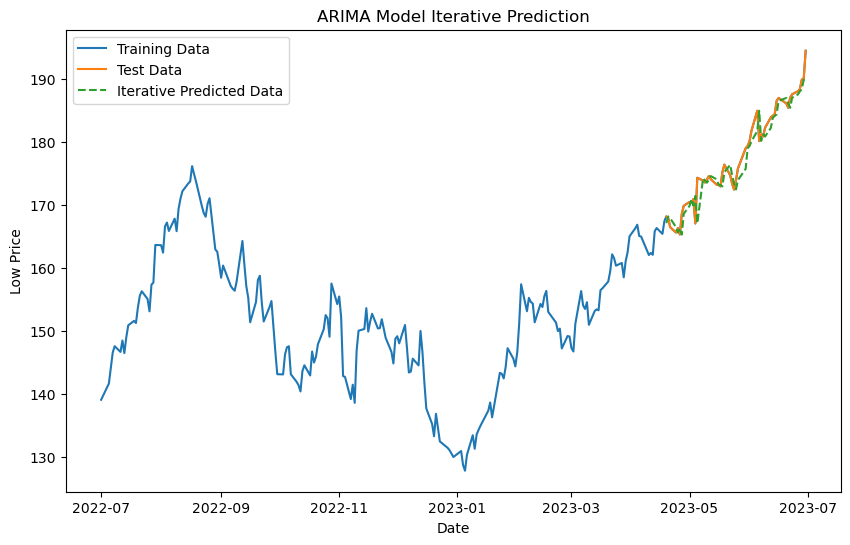

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(forecast_series_High, label='Iterative Predicted Data', linestyle='--')
ax.legend()
ax.set_title("ARIMA Model Iterative Prediction")
ax.set_xlabel("Date")
ax.set_ylabel("Low Price")
plt.show()

In [34]:
data = pd.DataFrame(df_extracted[['Mid']])
# data['Date'] = pd.to_datetime(data['Date'])
# data.set_index('Date', inplace=True)

train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]
predictions = []
predicted_dates = []
train, test = data[:train_size], data[train_size:]

for date in test.index:
    model = ARIMA(train, order=(1,1,1))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1).values
    predictions.append(forecast[0])
    predicted_dates.append(date)
    train = train.append(test.loc[date])

forecast_series_Mid = pd.Series(predictions, index=predicted_dates)
forecast_series_Mid.name = "Mid_forcast"
forecast_series_Mid.head()

C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer ind

2023-04-19    166.871300
2023-04-20    166.732088
2023-04-21    166.751436
2023-04-24    165.230728
2023-04-25    164.737284
Name: Mid_forcast, dtype: float64

In [35]:
mse = mean_squared_error(test, forecast_series_Mid)
print(f'MSE of middle price forecast: {mse}')

MSE of middle price forecast: 3.0610138523868713


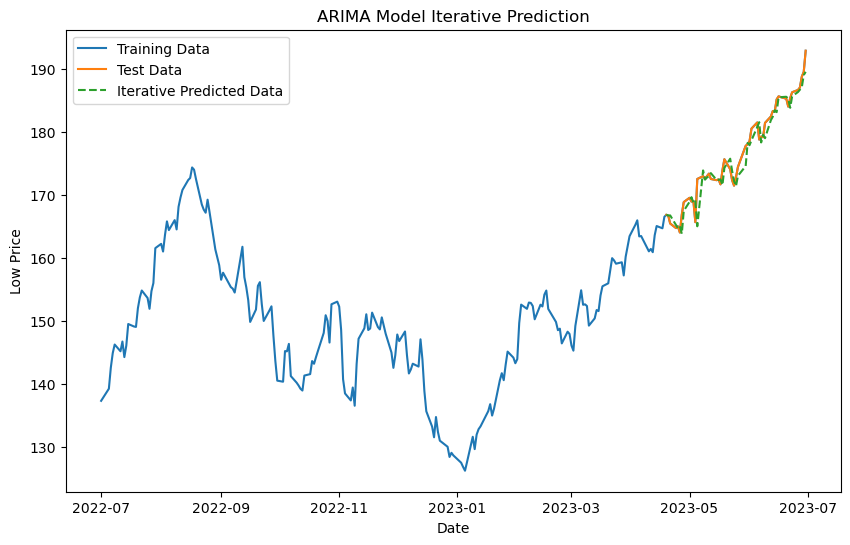

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(forecast_series_Mid, label='Iterative Predicted Data', linestyle='--')
ax.legend()
ax.set_title("ARIMA Model Iterative Prediction")
ax.set_xlabel("Date")
ax.set_ylabel("Low Price")
plt.show()

In [37]:
df_low = forecast_series_Low.to_frame(name="Low_forecast")
df_mid = forecast_series_Mid.to_frame(name="Mid_forecast")
df_high = forecast_series_High.to_frame(name="High_forecast")

merged_df = pd.merge(df_low, df_mid, left_index=True, right_index=True)
interval_df = pd.merge(merged_df, df_high, left_index=True, right_index=True)
interval_df.index.name = 'Date'
interval_df.head()

,Low_forecast,Mid_forecast,High_forecast
Date,,,
2023-04-19,165.893535,166.871300,167.090293
2023-04-20,165.429272,166.732088,168.150562
2023-04-21,165.606187,166.751436,167.865372
2023-04-24,164.326738,165.230728,166.469444
2023-04-25,163.871538,164.737284,165.606571


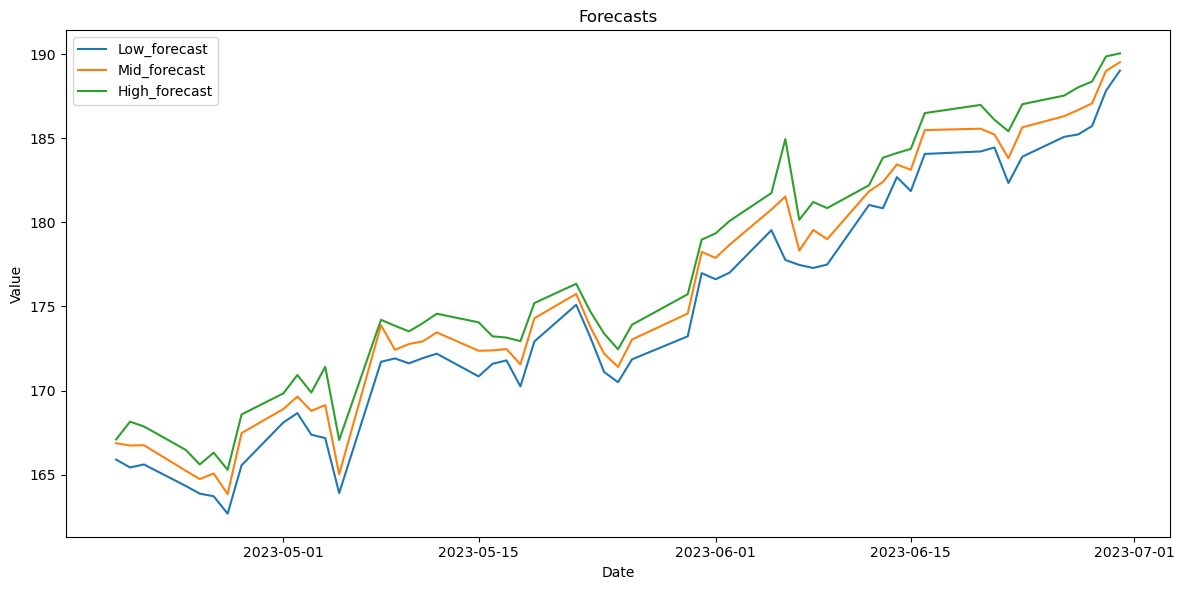

In [38]:
plt.figure(figsize=(12, 6))
for column in interval_df.columns:
    plt.plot(interval_df.index, interval_df[column], label=column)

plt.title('Forecasts')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

In [39]:
# Convert 'Low' and 'High' columns to intervals
interval_df['forecast_Interval'] = interval_df.apply(lambda row: pd.Interval(row['Low_forecast'], row['High_forecast'], closed='both'), axis=1)

data = interval_df[['forecast_Interval']]
df_mid = df_mid.rename(columns={df_mid.columns[0]: 'forecast_midpoint'})
data = data.join(df_mid)

data.to_csv('Forecast_Interval_Data.csv')
data.head()

,forecast_Interval,forecast_midpoint
Date,,
2023-04-19,"[165.89353500416235, 167.09029254910146]",166.871300
2023-04-20,"[165.4292722240734, 168.15056239923447]",166.732088
2023-04-21,"[165.606186508449, 167.86537227656805]",166.751436
2023-04-24,"[164.32673791116468, 166.46944364979277]",165.230728
2023-04-25,"[163.87153778257783, 165.6065714234981]",164.737284


In [40]:
df_forecast = pd.read_csv('Forecast_Interval_Data.csv')
df_real = pd.read_csv('Interval_Data.csv')
def trade_strategy(forecast, initial_capital):
    capital = initial_capital
    shares = 0
    buy_price = None
    sell_price = None
    buy_dates = []
    sell_dates = []

    for i in range(len(forecast) - 1):
        current_price = forecast[i]
        next_price = forecast[i + 1]

        if next_price > current_price and shares == 0:
            buy_price = current_price
            shares = capital // buy_price
            capital -= shares * buy_price
            buy_dates.append(forecast.index[i])

        elif next_price < current_price and shares > 0:
            sell_price = current_price
            capital += shares * sell_price
            shares = 0
            sell_dates.append(forecast.index[i])

    if shares > 0:
        capital += shares * forecast[-1]
        sell_dates.append(forecast.index[-1])

    return capital, buy_dates, sell_dates

forecast_price = df_forecast.set_index('Date')['forecast_midpoint']

# Execute the trading strategy based on the forecasted midpoint values
capital_after_trade, buy_dates, sell_dates = trade_strategy(forecast_price, 100000)

# Calculate the actual transaction amounts using the real midpoint data
real_prices = df_real.set_index("Date")["midpoint"]
actual_buy_prices = real_prices.loc[buy_dates]
actual_sell_prices = real_prices.loc[sell_dates]

actual_capital = 100000
actual_shares = 0

for buy_date, sell_date in zip(buy_dates, sell_dates):
    actual_buy_price = actual_buy_prices[buy_date]
    actual_sell_price = actual_sell_prices[sell_date]
    actual_shares = actual_capital // actual_buy_price
    actual_capital -= actual_shares * actual_buy_price
    actual_capital += actual_shares * actual_sell_price
    actual_shares = 0
print(f"Trading according to the trading strategy and using the forecast value, the amount after the trade is ${capital_after_trade}. But when we calculate the amount of the transaction using the actual data, the actual amount after the transaction is ${actual_capital}")
print(f"We buy stocks in these days: {buy_dates}")
print(f"We sell stocks in these days: {sell_dates}")

Trading according to the trading strategy and using the forecast value, the amount after the trade is $129231.07516815206. But when we calculate the amount of the transaction using the actual data, the actual amount after the transaction is $106081.43119650005
We buy stocks in these days: ['2023-04-20', '2023-04-25', '2023-04-27', '2023-05-03', '2023-05-05', '2023-05-09', '2023-05-15', '2023-05-18', '2023-05-25', '2023-06-01', '2023-06-07', '2023-06-09', '2023-06-15', '2023-06-22']
We sell stocks in these days: ['2023-04-21', '2023-04-26', '2023-05-02', '2023-05-04', '2023-05-08', '2023-05-12', '2023-05-17', '2023-05-22', '2023-05-31', '2023-06-06', '2023-06-08', '2023-06-14', '2023-06-20', '2023-06-30']


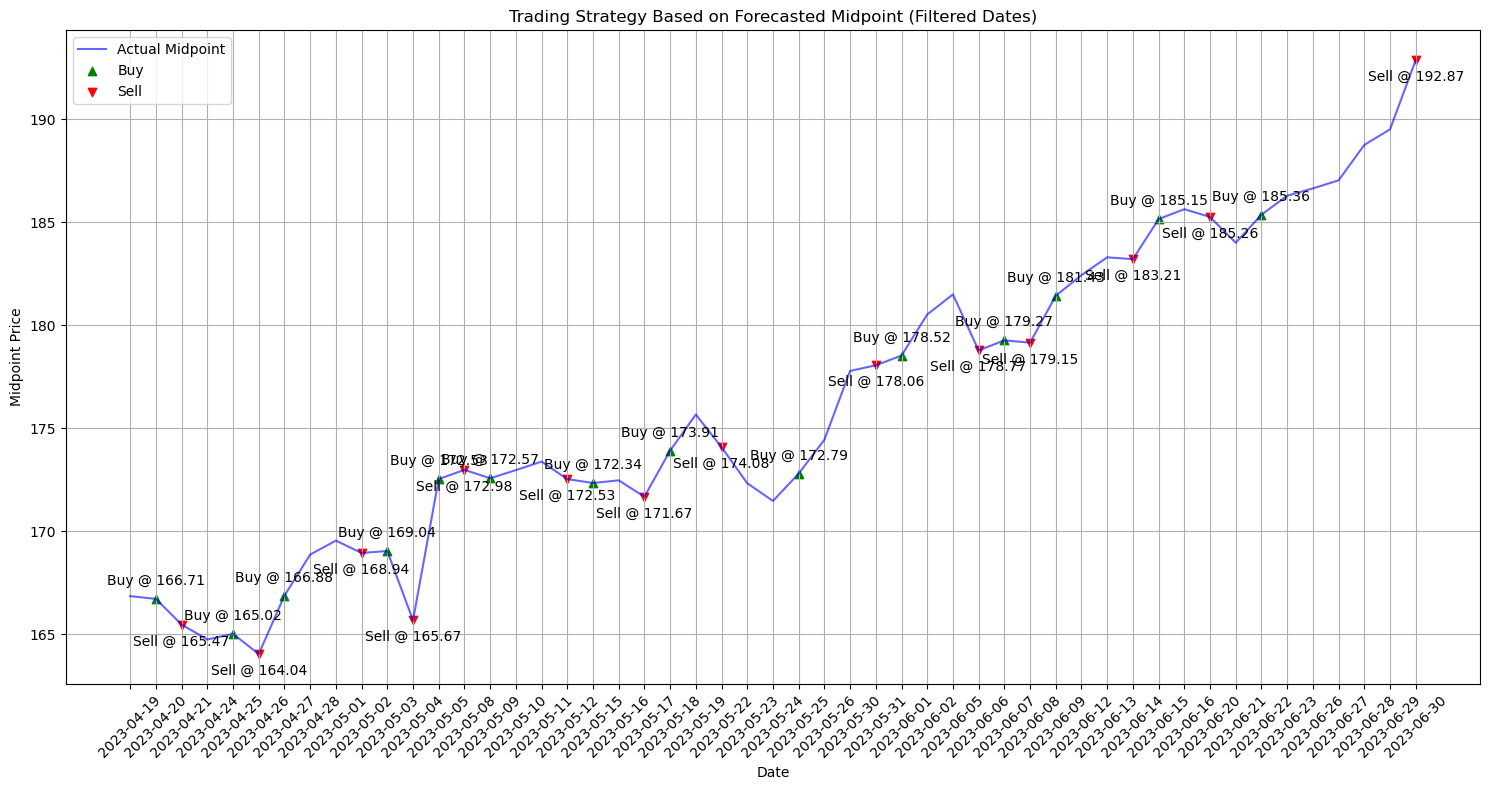

In [41]:
# Filter the real_prices
filtered_real_prices = real_prices[real_prices.index.isin(forecast_price.index)]
# Filter buy and sell dates
filtered_buy_dates = [date for date in buy_dates if date in forecast_price.index]
filtered_sell_dates = [date for date in sell_dates if date in forecast_price.index]
filtered_dates = filtered_real_prices.index

plt.figure(figsize=(15,8))
plt.plot(filtered_dates, filtered_real_prices, label="Actual Midpoint", color="blue", alpha=0.6)

# Highlight the buy and sell points
plt.scatter(filtered_buy_dates, filtered_real_prices.loc[filtered_buy_dates], color="green", label="Buy", marker="^", alpha=1)
plt.scatter(filtered_sell_dates, filtered_real_prices.loc[filtered_sell_dates], color="red", label="Sell", marker="v", alpha=1)

# Annotate the buy and sell points
for buy_date in filtered_buy_dates:
    price = filtered_real_prices.loc[buy_date]
    plt.annotate(f"Buy @ {price:.2f}", (buy_date, price), textcoords="offset points", xytext=(0,10), ha='center')
for sell_date in filtered_sell_dates:
    price = filtered_real_prices.loc[sell_date]
    plt.annotate(f"Sell @ {price:.2f}", (sell_date, price), textcoords="offset points", xytext=(0,-15), ha='center')

plt.title("Trading Strategy Based on Forecasted Midpoint (Filtered Dates)")
plt.xlabel("Date")
plt.ylabel("Midpoint Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [42]:
# data = pd.read_csv("AAPL.csv")
    # Split data for training

def train_test_split(data, prediction_size):
    train_size = int(len(data) * (1-prediction_size))
    train = pd.DataFrame(data[0:train_size])
    test = pd.DataFrame(data[train_size:len(data)])
    return train, test

In [43]:
from pmdarima import auto_arima
# 这里假设数据在 'stock_data.csv' 文件中，我们将其读取为 DataFrame
# 由于你的数据是中文的，可能需要制定encoding为'utf-8'
# data = pd.read_csv('AAPL.csv', encoding='utf-8')
# data = df_extracted


# 将 'Date' 列转换为 datetime 类型，并设为索引
# data['Date'] = pd.to_datetime(data['Date'])
# data.set_index('Date', inplace=True)

data = pd.DataFrame(df_extracted[['Low']])
# data['Date'] = pd.to_datetime(data['Date'])
# data.set_index('Date', inplace=True)

train, test = train_test_split(data['Low'], 0.2)


# 使用 auto_arima 函数找到最优的 ARIMA 模型
# arima_model = auto_arima(train,
#                    start_p=0, start_q=0,
#                    max_p=3, max_q=3, m=12,
#                    start_P=0, seasonal=True,
#                    d=1, D=1, trace=True,
#                    error_action='ignore',
#                    suppress_warnings=True,
#                    stepwise=True)
#
# arima_model.summary()

arima_model = auto_arima(train,start_p=0, d=1, start_q=0,
                                   max_p=3, max_d=3, max_q=3,
                                   start_P=0, D=1, start_Q=0,
                                   max_P=5, max_D=5, max_Q=5,
                                   m=12, seasonal=True,
                                   error_action='warn', trace=True,
                                   suppress_warnings=True, stepwise=True,
                                   random_state=20, n_fits=50)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1024.453, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=974.644, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1024.711, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=949.352, Time=0.27 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=944.997, Time=0.79 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=939.995, Time=1.15 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=938.044, Time=3.17 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=22.63 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=10.96 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=938.741, Time=2.32 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=939.519, Time=3.24 sec
 ARIMA(1,1,1)(5,1,0)[12]             : AIC=939.605, Time=5.12 sec
 ARIMA(0,1,1)(5,1,0)[12]             : AIC=937.795, Time=2.95 sec
 ARIMA(0,1,1)(4,1,0)[12]             : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  200
Model:             SARIMAX(0, 1, 1)x(5, 1, [], 12)   Log Likelihood                -461.898
Date:                             Sat, 12 Aug 2023   AIC                            937.795
Time:                                     17:49:39   BIC                            960.413
Sample:                                          0   HQIC                           946.960
                                             - 200                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1326      0.076      1.756      0.079      -0.015       0.281
ar.S.L12      -0.8700      0.076    -11.489      0.000      -1.018      -0.722
ar.S.L24      -0.7075      0.108     -6.538      0.000      -0.920      -0.495
ar.S.L36      -0.4819      0.126     -3.831      0.000      -0.728      -0.235
ar.S.L48      -0.3588      0.129     -2.788      0.005      -0.611      -0.107
ar.S.L60      -0.1710      0.103     -1.667      0.095      -0.372       0.030
sigma2         7.6287      0.773      9.865      0.000       6.113       9.144
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.48
Prob(Q):                              0.95   Prob(JB):                         0.78
Heteroskedasticity (H):               0.64   Skew:                             0.10
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Date
2023-04-19    167.258770
2023-04-20    168.002437
2023-04-21    167.731497
2023-04-24    168.674400
2023-04-25    169.774178
2023-04-26    171.719543
2023-04-27    171.347083
2023-04-28    170.987483
2023-05-01    172.251517
2023-05-02    171.601418
2023-05-03    172.545202
2023-05-04    173.472933
2023-05-05    174.687272
2023-05-08    175.740826
2023-05-09    175.741706
2023-05-10    176.007968
2023-05-11    177.335184
2023-05-12    178.656669
2023-05-15    178.352903
2023-05-16    177.678309
2023-05-17    178.630221
2023-05-18    177.894269
2023-05-19    179.341945
2023-05-22    180.144943
2023-05-23    181.102060
2023-05-24    181.847929
2023-05-25    181.782597
2023-05-26    181.290119
2023-05-30    182.614472
2023-05-31    184.322280
2023-06-01    183.946087
2023-06-02    183.360059
2023-06-05    183.343902
2023-06-06    182.745605
2023-06-07    183.579821
2023-06-08    184.627435
2023-06-09    185.653001
2023-06-12    186.590181
2023-06-13    186.814708
2023-06-14    186.38

C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\eq220\.conda\envs\Finalproject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


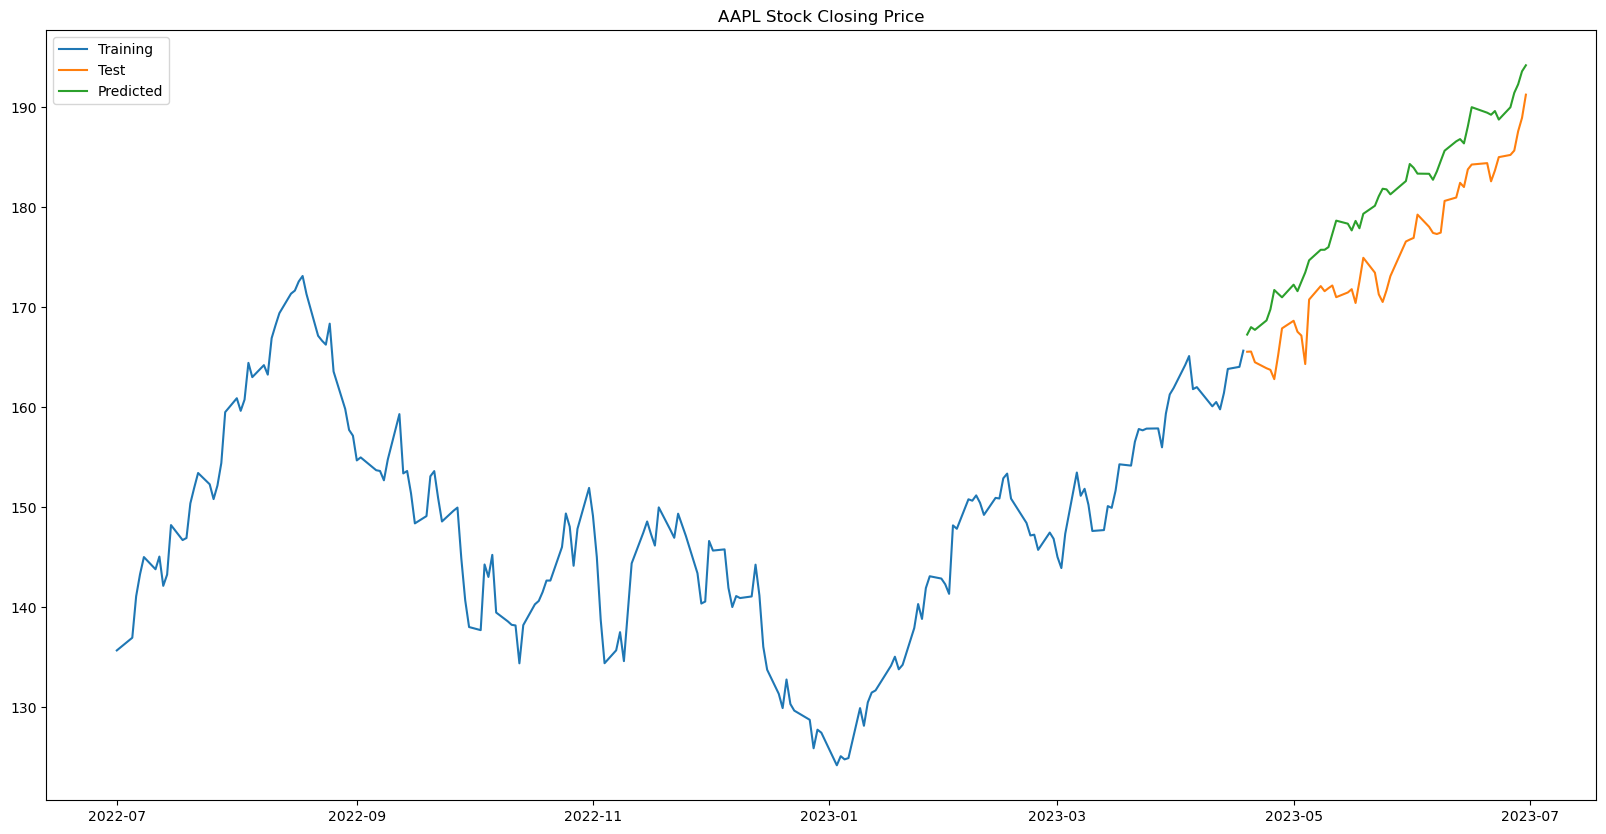

In [44]:
import matplotlib.pyplot as plt

# Create a DataFrame for the predicted values
# prediction = pd.DataFrame(arima_model.predict(n_periods = len(test)), index = test.index)
# prediction.columns = ['Close']
# forecast_result = model_fit.forecast(steps=len(test))
# # Create a new series with predictions
# forecast_series = pd.Series(forecast_result.values, index=test.index)
# model_fit = arima_model.fit()
# forecast_result = model_fit.forecast(steps=len(test))
# forecast_series = pd.Series(forecast_result.values, index=test.index)
# print(forecast_series)

# Use the model to make predictions
forecast_result = arima_model.predict(n_periods=len(test))

# Create a series with the predictions
forecast_series = pd.Series(forecast_result.values, index=test.index)

print(forecast_series)

# Plot the results
plt.figure(figsize=(20,10))
plt.plot(train, label="Training")
plt.plot(test, label="Test")
plt.plot(forecast_series, label="Predicted")
plt.title("AAPL Stock Closing Price")
plt.legend(loc='best')
plt.show()
